<a href="https://colab.research.google.com/github/cleftwitch28/SOCL-PYQT5/blob/main/RNN_SOCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn

In [4]:
BATCH_SIZE = 28

# list all transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))  # Resize the image to 28x28 pixels
])
train_dir="/content/drive/MyDrive/Dataset/Train"
test_dir="/content/drive/MyDrive/Dataset/test"
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# parameters
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 4
N_EPHOCS = 10

In [15]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)

        self.FC = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, BATCH_SIZE, self.n_neurons))

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(0, 2, 1)
        X.size(1)

        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
        out = self.FC(self.hidden)

        return out.view(-1, self.n_outputs) # batch_size X n_output

In [22]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
class_weights = torch.ones(4)
class_weights[0] = 5.5
class_weights[1] = 5.0
class_weights[2] = 5.5
class_weights[3] = 5.0
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    predictions = torch.argmax(logit, dim=1)
    corrects = (predictions == target).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [17]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        model.hidden = model.init_hidden()


        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28)

        # forward + backward + optimize
        outputs = model(inputs)
        current_batch_size = labels.size(0)
        loss = criterion(outputs[:current_batch_size], labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs[:current_batch_size], labels, current_batch_size)

    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 1.3448 | Train Accuracy: 43.46
Epoch:  1 | Loss: 1.3298 | Train Accuracy: 44.29
Epoch:  2 | Loss: 1.3261 | Train Accuracy: 44.17
Epoch:  3 | Loss: 1.3339 | Train Accuracy: 44.23
Epoch:  4 | Loss: 1.3266 | Train Accuracy: 44.17
Epoch:  5 | Loss: 1.3302 | Train Accuracy: 44.48
Epoch:  6 | Loss: 1.3294 | Train Accuracy: 44.48
Epoch:  7 | Loss: 1.3299 | Train Accuracy: 44.29
Epoch:  8 | Loss: 1.3244 | Train Accuracy: 44.35
Epoch:  9 | Loss: 1.3264 | Train Accuracy: 44.35


In [38]:
test_acc = 0.0
with torch.no_grad():
  for i, data in enumerate(test_loader, 0):
      inputs, labels = data
      inputs = inputs.view(-1, 28, 28)

      outputs = model(inputs)
      current_batch_size = labels.size(0)

      test_acc += get_accuracy(outputs[:current_batch_size], labels, current_batch_size)

  print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 22.92


torch.Size([4, 4])


<ipython-input-40-d6a763ba6c31>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(labels)  # Replace with your ground truth
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


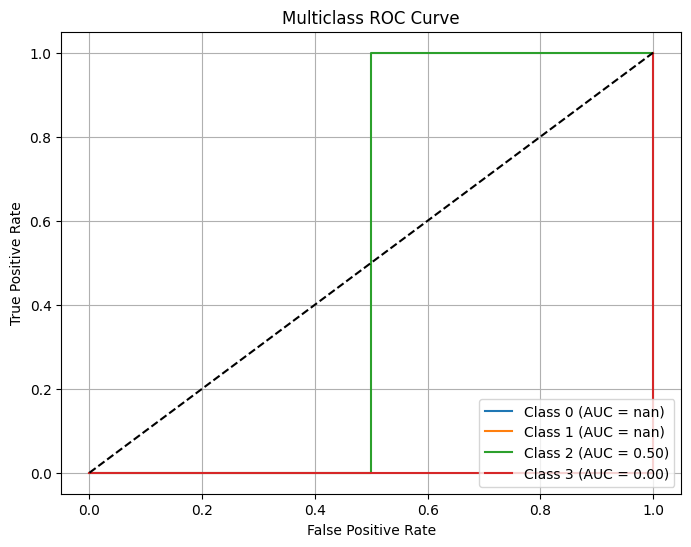

Multiclass AUROC: 0.1250


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


In [40]:
!pip install torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
from torchmetrics.classification import MulticlassAUROC


y_score = outputs[:4]
print(y_score.shape)


y_true = torch.tensor(labels)  # Replace with your ground truth

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot individual curves
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()

metric = MulticlassAUROC(num_classes=4)
metric.update(y_score, y_true)
auroc = metric.compute()
print(f"Multiclass AUROC: {auroc:.4f}")


<ipython-input-46-b33170ab8640>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels_tensor = torch.tensor(outputs[:4])
<ipython-input-46-b33170ab8640>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_tensor = torch.tensor(labels)


F1 score (weighted-average): 0.3333


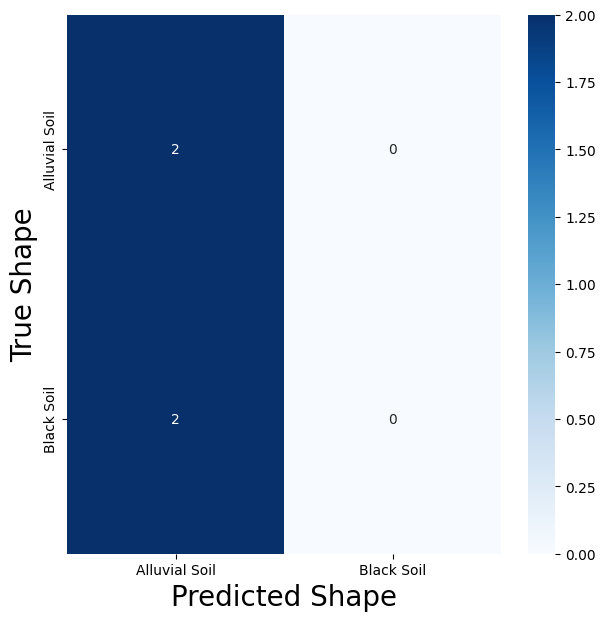

In [46]:
from torchmetrics.classification import MulticlassF1Score
true_labels_tensor = torch.tensor(outputs[:4])
predictions_tensor = torch.tensor(labels)
num_classes = 4
f1_macro = MulticlassF1Score(num_classes=num_classes, average='weighted')
f1_macro.update(true_labels_tensor,predictions_tensor)
print(f"F1 score (weighted-average): {f1_macro.compute():.4f}")
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
classes=["Alluvial Soil","Black Soil"]
predicted_labels = torch.argmax(outputs[:4], dim=1)
cm = confusion_matrix(labels, predicted_labels)
tick_marks = np.arange(len(classes))
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()